In [ ]:
# 1. 필요한 라이브러리 설치
!pip install geopandas contextily shapely

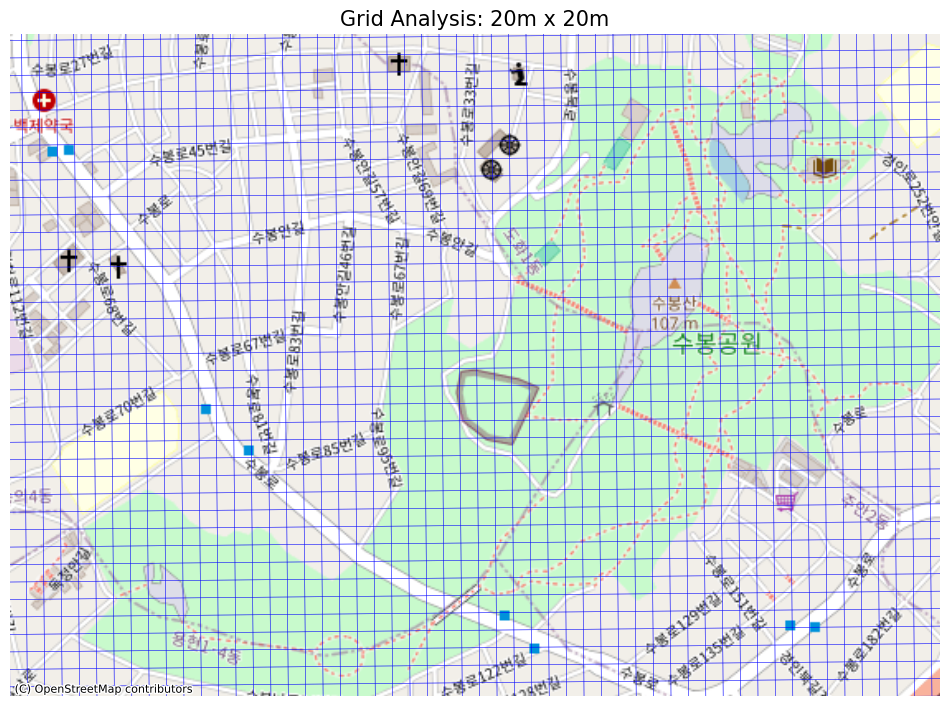

총 생성된 격자 수: 2106개


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import contextily as cx
from shapely.geometry import box

# 2. 사용자 입력: 위도 및 경도의 최소/최대값
min_lat, max_lat = 37.457235, 37.464065
min_lon, max_lon = 126.656255, 126.668345

# 3. 분석 범위 생성 및 좌표계 변환
# WGS84(4326)로 시작하여 거리 계산을 위해 EPSG:5179(미터 단위)로 변환
bbox_geom = box(min_lon, min_lat, max_lon, max_lat)
gdf_bbox = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs="EPSG:4326")
gdf_bbox_5179 = gdf_bbox.to_crs(epsg=5179)

# 4. 20m 단위 격자(Polygon) 생성
min_x, min_y, max_x, max_y = gdf_bbox_5179.total_bounds
grid_size = 20

x_coords = np.arange(min_x, max_x, grid_size)
y_coords = np.arange(min_y, max_y, grid_size)

grid_polygons = [
    box(x, y, x + grid_size, y + grid_size)
    for x in x_coords
    for y in y_coords
]
gdf_grid = gpd.GeoDataFrame({'geometry': grid_polygons}, crs="EPSG:5179")

# 5. 시각화를 위해 다시 지도 타일 좌표계(EPSG:3857)로 변환
gdf_grid_3857 = gdf_grid.to_crs(epsg=3857)
view_limit = gdf_bbox.to_crs(epsg=3857).total_bounds # 시각화 범위 제한용

# 6. 지도 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 격자 경계선 그리기
gdf_grid_3857.boundary.plot(ax=ax, linewidth=0.4, color='blue', alpha=0.6, label='20m Grid')

# 배경 지도 추가 (OpenStreetMap)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# 입력한 범위로 지도 크기 제한 (지정한 부분만 보이게 함)
ax.set_xlim(view_limit[0], view_limit[2])
ax.set_ylim(view_limit[1], view_limit[3])

ax.set_axis_off()
plt.title(f"Grid Analysis: {grid_size}m x {grid_size}m", fontsize=15)
plt.show()

print(f"총 생성된 격자 수: {len(gdf_grid)}개")

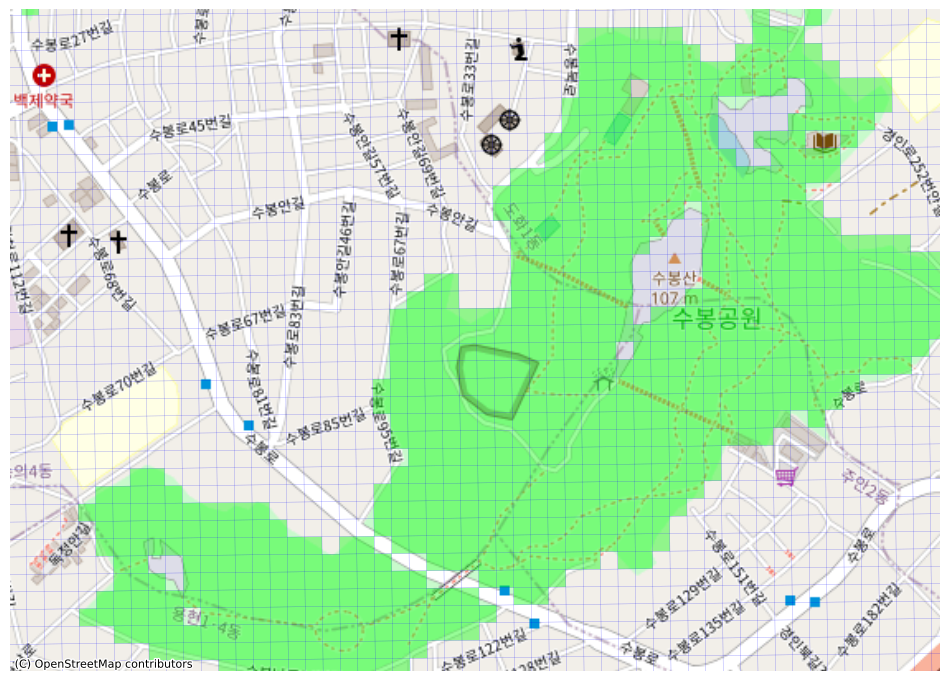

분석 완료: 행/열 정보가 포함된 'grid_analysis.csv'가 생성되었습니다.


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import contextily as cx
from shapely.geometry import box
import pandas as pd
import cv2
from io import BytesIO

# 1. 설정값
TREE_THRESHOLD = 0.3

# 2. 사용자 입력 및 좌표계 설정
min_lat, max_lat = 37.457235, 37.464065
min_lon, max_lon = 126.656255, 126.668345

bbox_geom = box(min_lon, min_lat, max_lon, max_lat)
gdf_bbox = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs="EPSG:4326")
gdf_bbox_5179 = gdf_bbox.to_crs(epsg=5179)

# 3. 20m 단위 격자 생성 및 행/열 정보 할당
min_x, min_y, max_x, max_y = gdf_bbox_5179.total_bounds
grid_size = 20
x_coords = np.arange(min_x, max_x, grid_size)
y_coords = np.arange(min_y, max_y, grid_size)

grid_polygons = []
grid_info = []

# y좌표는 위에서 아래로(행), x좌표는 왼쪽에서 오른쪽으로(열) 계산
for r_idx, y in enumerate(reversed(y_coords)): # 위쪽이 0행이 되도록 reversed
    for c_idx, x in enumerate(x_coords):
        poly = box(x, y, x + grid_size, y + grid_size)
        grid_polygons.append(poly)
        grid_info.append({'row_index': r_idx, 'col_index': c_idx})

gdf_grid = gpd.GeoDataFrame(grid_info, geometry=grid_polygons, crs="EPSG:5179")
gdf_grid['center'] = gdf_grid.geometry.centroid
gdf_grid_4326 = gdf_grid.to_crs(epsg=4326)

# 4. 지도 이미지 캡처
fig, ax = plt.subplots(figsize=(12, 12))
view_limit = gdf_bbox.to_crs(epsg=3857).total_bounds
ax.set_xlim(view_limit[0], view_limit[2])
ax.set_ylim(view_limit[1], view_limit[3])
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

buffer = BytesIO()
plt.savefig(buffer, format='png', bbox_inches='tight', pad_inches=0)
buffer.seek(0)
img = cv2.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), cv2.IMREAD_COLOR)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 나무 색상 범위 (연두~초록)
lower_tree = np.array([35, 30, 50])
upper_tree = np.array([85, 255, 255])
tree_mask = cv2.inRange(img_hsv, lower_tree, upper_tree)

# 5. 격자별 분석
h, w = tree_mask.shape
results = []
tree_indices = []

for i, row in gdf_grid.iterrows():
    bx = row['geometry'].bounds
    px_min = int((bx[0] - min_x) / (max_x - min_x) * w)
    px_max = int((bx[2] - min_x) / (max_x - min_x) * w)
    py_min = h - int((bx[3] - min_y) / (max_y - min_y) * h)
    py_max = h - int((bx[1] - min_y) / (max_y - min_y) * h)

    t_cell = tree_mask[max(0, py_min):min(h, py_max), max(0, px_min):min(w, px_max)]
    t_ratio = np.count_nonzero(t_cell) / t_cell.size if t_cell.size > 0 else 0

    is_tree = 1 if t_ratio >= TREE_THRESHOLD else 0
    if is_tree:
        tree_indices.append(i)

    center = gdf_grid_4326.iloc[i]['center']
    results.append({
        'grid_id': i,
        'row_index': row['row_index'],
        'col_index': row['col_index'],
        'lon': center.x,
        'lat': center.y,
        'is_tree': is_tree
    })

# 6. CSV 저장
pd.DataFrame(results).to_csv('grid_analysis.csv', index=False)

# 7. 시각화
gdf_grid_3857 = gdf_grid.to_crs(epsg=3857)
if tree_indices:
    gdf_grid_3857.iloc[tree_indices].plot(ax=ax, color='lime', alpha=0.4)
gdf_grid_3857.boundary.plot(ax=ax, linewidth=0.2, color='blue', alpha=0.3)
plt.show()

print(f"분석 완료: 행/열 정보가 포함된 'grid_analysis.csv'가 생성되었습니다.")